In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import datetime
from math import ceil


In [23]:
def start_plot():
    fig, ax = plt.subplots()
    ax.set_xlabel("Czas trwania testu [h]")

    return (fig, ax)

start_cloudwatch = datetime(2023, 1, 15, 17, 58)
end_cloudwatch = datetime(2023, 1, 15, 18, 28)
duration = np.timedelta64(30, 'm')
duration_serverless = np.timedelta64(30, 'm')
def to_delta(df, column):
    # start = df[column].min()
    df[column] = df[column].apply(lambda dt: dt - start_cloudwatch)
    df.set_index(column, inplace=True, drop=False)

def load_cloudwatch(filename):
    logs = pd.read_csv(filename)
    logs = logs.sort_values(by='timestamp')
    logs['timestamp'] = pd.to_datetime(logs['timestamp'])
    logs = logs[logs['timestamp'] >= start_cloudwatch]
    logs = logs[logs['timestamp'] <= end_cloudwatch]
    to_delta(logs, 'timestamp')
    return logs

def start_plot():
    fig, ax = plt.subplots()
    ax.set_xlabel("Czas trwania testu [h]")

    return (fig, ax)

def human_delta(index):
    return index.get_level_values('timestamp').seconds / 60 / 60

In [24]:
def plot_metric(ax, df, allowlist, y, prefix=None, title=None, suffix=True, type='median', period='5T', **kwargs):
    if type == 'median':
        df = df.groupby('Name').resample(period).median(numeric_only=True)
    elif type == 'p99':
        df = df.groupby('Name').resample(period).quantile(q=0.99, numeric_only=True)
    elif type == 'sum':
        df = df.groupby('Name').resample(period).sum(numeric_only=True)
    elif type == 'mean':
        df = df.groupby('Name').resample(period).mean(numeric_only=True)
    elif type == 'raw':
        pass
    else:
        raise Exception("unkown type")
    if title is not None:
        ax.set_title(title)
    # for name in df.index.get_level_values('Name').unique():
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink', 'tab:purple']
    for (index, name) in enumerate(allowlist):
        if type  == 'raw':
            new_df = df[df.Name == name]
        else:
            new_df = df[df.index.get_level_values('Name') == name]
        if prefix is not None:
            label = f"{prefix}"
            if suffix:
                label = f"{label} - {name}"
        else:
            label = name
        color = kwargs.pop('color') if 'color' in kwargs else None
        ax.plot(new_df.index.get_level_values('Timestamp').seconds / 60 / 60, new_df[y], label=label, color=color if color else colors[index], **kwargs)



In [25]:
def load_locust(filename):
    df =  pd.read_csv(filename)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
    start = df['Timestamp'][0]
    df['Timestamp'] = df['Timestamp'].apply(lambda dt: dt - start)
    df.set_index('Timestamp', inplace=True, drop=False)
    df = df[df['Timestamp'] <= duration]
    return df

In [26]:
serverless = load_locust('../load-tests/RAW/serverless_without_burst/load-1/current_load_test_stats_history.csv')
serverless_optimized = load_locust('../load-tests/RAW/serverless_optimized_burst/load-1/current_load_test_stats_history.csv')
ec2 = load_locust('../load-tests/RAW/ec2_without_burst/load-1/current_load_test_stats_history.csv')

ec2['ErrorPercentage'] = ec2['Failures/s'] / ec2['Requests/s']
serverless['ErrorPercentage'] = serverless['Failures/s'] / serverless['Requests/s']
serverless_optimized['ErrorPercentage'] = serverless_optimized['Failures/s'] / serverless_optimized['Requests/s']

In [27]:
selected_metric = 'Total Median Response Time'
selected_metric_desc = 'Mediana czasu odpowiedzi [ms]'

Text(0, 0.5, 'Liczba aktywnych użytkowników')

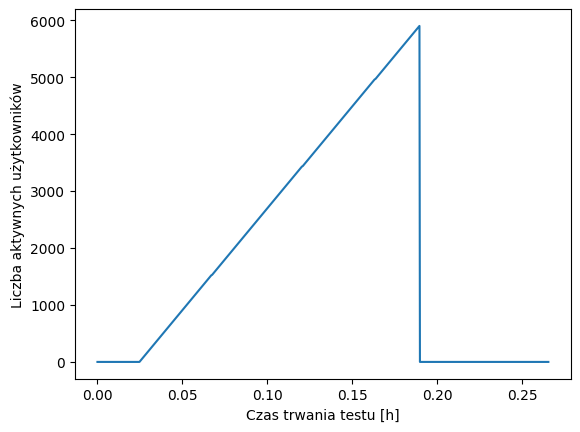

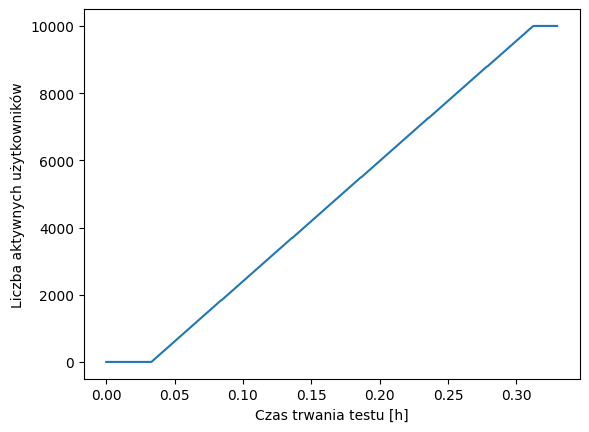

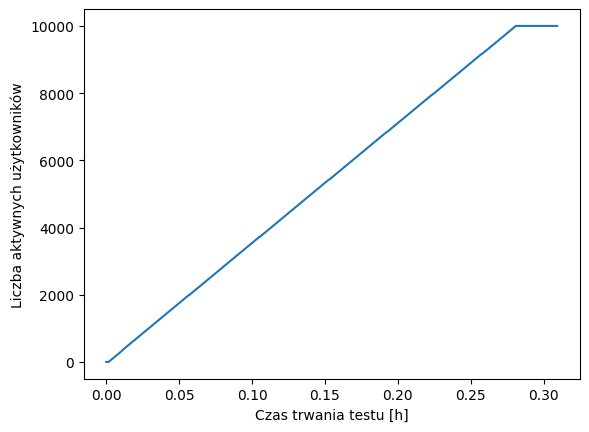

In [28]:
fig, ax = start_plot()

df = ec2[ec2.Name == 'Aggregated']
ax.plot(df['Timestamp'].dt.seconds / 60 / 60, df['User Count'])
ax.set_ylabel('Liczba aktywnych użytkowników')

fig, ax = start_plot()
df = serverless[serverless.Name == 'Aggregated']
ax.plot(df['Timestamp'].dt.seconds / 60 / 60, df['User Count'])
ax.set_ylabel('Liczba aktywnych użytkowników')

fig, ax = start_plot()
df = serverless_optimized[serverless_optimized.Name == 'Aggregated']
ax.plot(df['Timestamp'].dt.seconds / 60 / 60, df['User Count'])
ax.set_ylabel('Liczba aktywnych użytkowników')


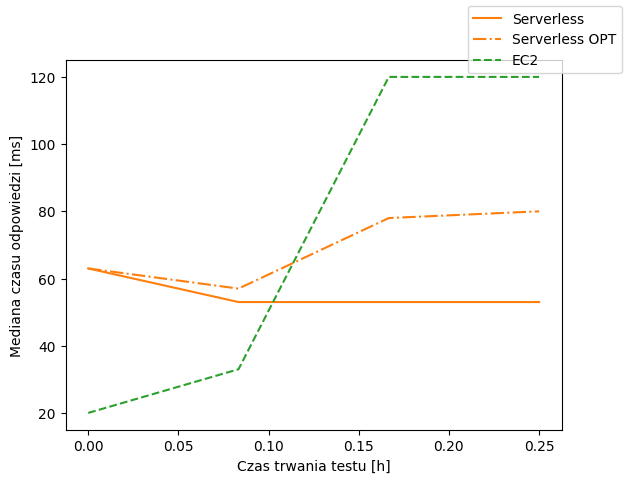

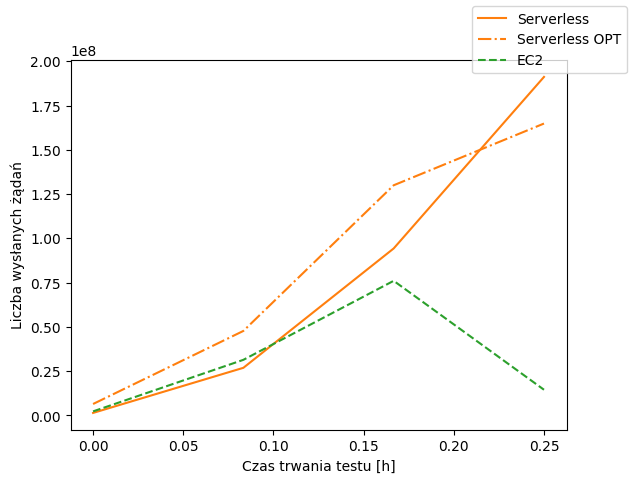

In [29]:
ops = ['Aggregated']
fig, ax = start_plot()
plot_metric(ax, serverless, ops, selected_metric, prefix='Serverless', suffix=False, color='tab:orange')
plot_metric(ax, serverless_optimized, ops, selected_metric, prefix='Serverless OPT', suffix=False, color='tab:orange', linestyle='-.')
plot_metric(ax, ec2, ops, selected_metric, prefix='EC2', suffix=False, linestyle='--', color='tab:green')
ax.set_ylabel(selected_metric_desc)
fig.legend()

ops = ['Aggregated']
fig, ax = start_plot()
plot_metric(ax, serverless, ops, 'Total Request Count', prefix='Serverless', suffix=False, type='sum', color='tab:orange')
plot_metric(ax, serverless_optimized, ops, 'Total Request Count', prefix='Serverless OPT', suffix=False, type='sum', color='tab:orange', linestyle='-.')
plot_metric(ax, ec2, ops, 'Total Request Count', prefix='EC2', suffix=False, type='sum', linestyle='--', color='tab:green')
ax.set_ylabel('Liczba wysłanych żądań')
fig.legend()


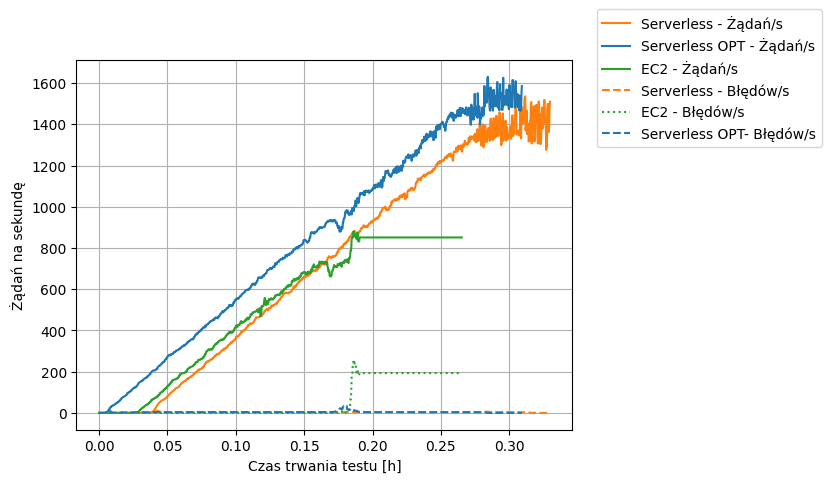

In [31]:
ops = ['Aggregated']
type_agg = 'raw'
period = '1T'
fig, ax = start_plot()
plot_metric(ax, serverless, ops, 'Requests/s', prefix='Serverless - Żądań/s', suffix=False, type=type_agg, period=period, color='tab:orange')
plot_metric(ax, serverless_optimized, ops, 'Requests/s', prefix='Serverless OPT - Żądań/s', suffix=False, type=type_agg, period=period, color='tab:blue')
plot_metric(ax, ec2, ops, 'Requests/s', prefix='EC2 - Żądań/s', suffix=False, type=type_agg, period=period, color='tab:green')

# ax2 = ax.twinx()
plot_metric(ax, serverless, ops, 'Failures/s', prefix='Serverless - Błędów/s', suffix=False, type=type_agg, period=period, color='tab:orange', linestyle='--')
plot_metric(ax, ec2, ops, 'Failures/s', prefix='EC2 - Błędów/s', suffix=False, type=type_agg, period=period, linestyle=':', color='tab:green')
plot_metric(ax, serverless_optimized, ops, 'Failures/s', prefix='Serverless OPT- Błędów/s', suffix=False, type=type_agg, period=period, color='tab:blue', linestyle='--')

ax.set_ylabel('Żądań na sekundę')
fig.legend(bbox_to_anchor=(0.8, 0, 0.5, 1))
ax.grid()

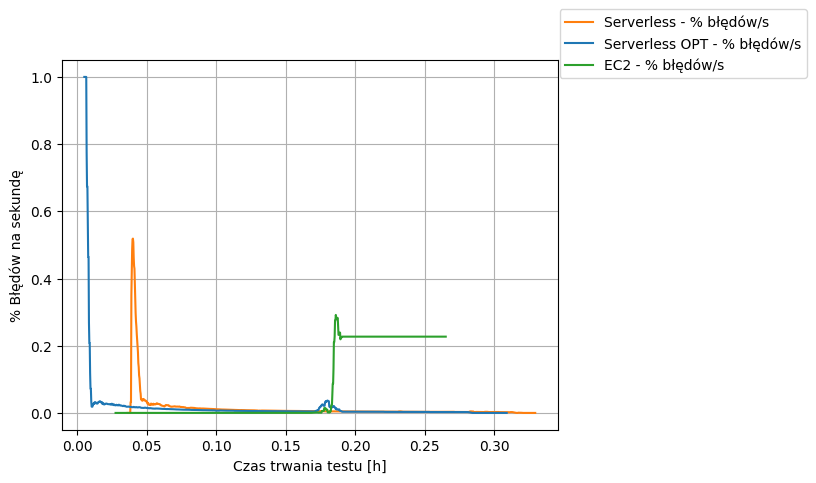

In [32]:
ops = ['Aggregated']
fig, ax = start_plot()
plot_metric(ax, serverless, ops, 'ErrorPercentage', prefix='Serverless - % błędów/s', suffix=False, type='raw', color='tab:orange')
plot_metric(ax, serverless_optimized, ops, 'ErrorPercentage', prefix='Serverless OPT - % błędów/s', suffix=False, type='raw', color='tab:blue')

plot_metric(ax, ec2, ops, 'ErrorPercentage', prefix='EC2 - % błędów/s', suffix=False, type='raw', color='tab:green')
# ax2 = ax.twinx()
ax.grid()
ax.set_ylabel('% Błędów na sekundę')
fig.legend(bbox_to_anchor=(0.8, 0, 0.5, 1))


In [34]:
prefix = '../load-tests/RAW/serverless_without_burst/cloudwatch/'

concurrent_naive = load_cloudwatch(f"{prefix}/concurrentExecutions.csv")
dbConns_naive = load_cloudwatch(f"{prefix}/databaseConnections.csv")
dbCPU_naive = load_cloudwatch(f"{prefix}/dbCPU.csv")
throttles_naive = load_cloudwatch(f"{prefix}/throttles.csv")

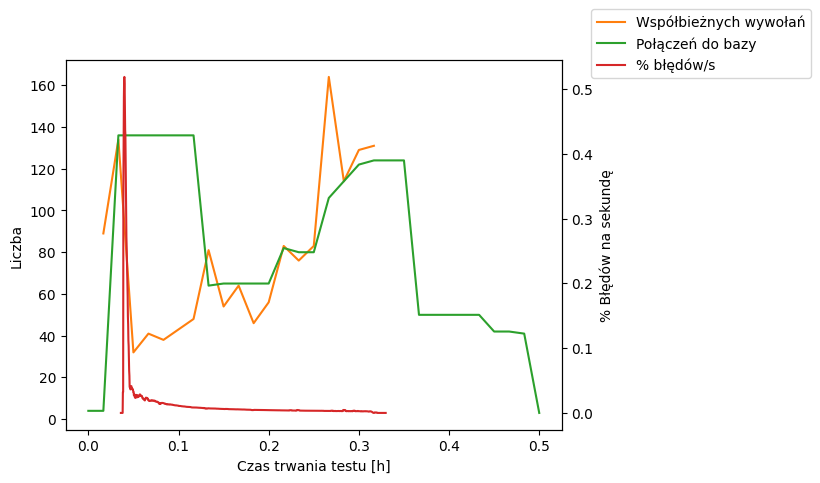

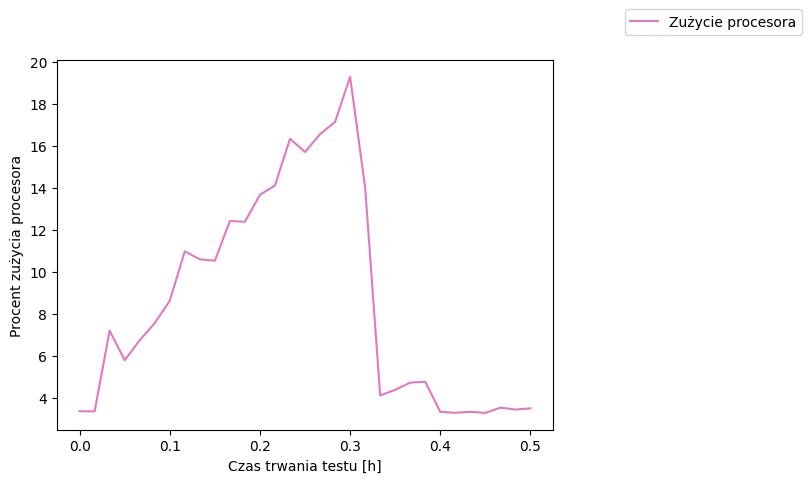

In [35]:
fig, ax = start_plot()
ax.plot(human_delta(concurrent_naive.index), concurrent_naive['concurrentExecutions'], label="Współbieżnych wywołań", color='tab:orange')
ax.plot(human_delta(dbConns_naive.index), dbConns_naive['dbConnections'], label="Połączeń do bazy", color='tab:green')
ax.set_ylabel("Liczba")
ax2 = ax.twinx()


ops = ['Aggregated']
plot_metric(ax2, serverless[serverless['Timestamp'] < duration_serverless], ops, 'ErrorPercentage', prefix='% błędów/s', suffix=False, type='raw', color='tab:red')
ax2.set_ylabel('% Błędów na sekundę')
fig.legend(bbox_to_anchor=(0.8, 0, 0.5, 1))

fig, ax = start_plot()
ax.set_ylabel('Procent zużycia procesora')
ax.plot(human_delta(dbCPU_naive.index), dbCPU_naive['cpu'], label="Zużycie procesora", color='tab:pink')
fig.legend(bbox_to_anchor=(0.8, 0, 0.5, 1))
